In [1]:
import pandas as pd

In [2]:
data = pd.read_excel("../data/raw/DFSS_GB_Wk1_Rev16/Manufacturing Data.xlsx")

In [3]:
import numpy as np
import scipy.stats as stats

def calculate_d2(n: int) -> float:
    standard_normal = stats.norm()
    approx_x, dx = np.linspace(-20.0, 20.0, 1001, retstep=True)
    sample_vals = (
        1.0
        - (1.0 - standard_normal.cdf(approx_x)) ** n
        - standard_normal.cdf(approx_x) ** n
    )
    return np.trapz(sample_vals, dx=dx)

In [4]:
import numpy as np

def calculate_process(x, LSL, USL, window=10):
    mu = x.mean()
    std = x.std()
    r = x.rolling(window)
    Rbar = r.max() - r.min()
    std_within = (Rbar/calculate_d2(window)).mean()

    ppk = np.min([
        (USL-mu)/(3*std),
        (mu-LSL)/(3*std)
    ])
    
    cpk = np.min([
        (USL-mu)/(3*std_within),
        (mu-LSL)/(3*std_within)
    ])

    d = {
        "mean": mu,
        "std": std,
        "ppk": ppk,
        "cpk": cpk
    }
    return pd.Series(d, index=['mean', 'std', 'ppk', 'cpk'])

In [5]:
calculate_process(data.Final, LSL=21, USL=24)

mean    23.905522
std      0.497079
ppk      0.063355
cpk      0.090189
dtype: float64

# Calculating $P_{pk}$ and $C_{pk}$

The difference between $P_{pk}$ and $C_{pk}$ is the definition of the standard deviation; for the former, we want to use the overall standard deviation, and for the latter, we want to use the standard deviation within a subgroup, meaning, devoid of a mean shifts.

In the below plot we plot the raw signal, then use either chunks of size `chunk_size` or a rolling mean with a window size `window_size` to calculate $\bar{R}$, or the process range. We then calculate the standard deviation $\sigma_{within}$  = $\bar{R} / d_{2}$.

(0.46028985494871183, 0.34980279106172846, 0.34906518071556863)

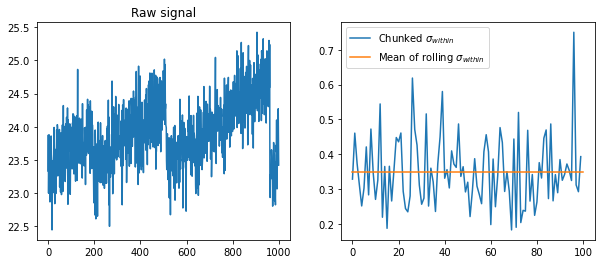

In [6]:
import pylab as pl

# Overall
sigma_overall = (data.Final.max() - data.Final.min()) / calculate_d2(len(data.Final))

# Rolling
window_size = 2
r = data.Final.rolling(window_size)
Rbar = r.max() - r.min()
sigma_within_rolling = (Rbar/calculate_d2(window_size)).mean()

# Chunks
chunk_size = 10
chunks = np.array_split(data.Final, len(data.Final)//chunk_size)
sigma_within = []
for chunk in chunks:
    Rbar = chunk.max() - chunk.min()
    sigma_within += [Rbar / calculate_d2(chunk_size)]
sigma_within_chunks = np.mean(sigma_within)

# Plot
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 4))
ax1.plot(data.Final)
ax1.set_title("Raw signal")
ax2.plot(sigma_within, label="Chunked $\sigma_{within}$")
ax2.plot([0, len(sigma_within)], [sigma_within_rolling, sigma_within_rolling], label="Mean of rolling $\sigma_{within}$")
ax2.legend()

sigma_overall, sigma_within_chunks, sigma_within_rolling